In [1]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [9]:
from torchvision import datasets as Datasets
from torchvision import transforms

mnist_train_transforms = transforms.Compose([
    transforms.ToTensor(),
])
mnist_test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

training_set = Datasets.MNIST(root='../../autoencoder', download=False, train=True, transform=mnist_train_transforms)
validation_set = Datasets.MNIST(root='../../autoencoder', download=False, train=False, transform=mnist_test_transforms)

In [10]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [87]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [88]:
# Create train loader
train_loader = DataLoader(training_set, batch_size=128, shuffle=True, num_workers=16, pin_memory=True)

In [91]:
num_epochs = 2
model.train()
for epoch in range(num_epochs):
    for data in tqdm(train_loader):
        img, _ = data
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item()}')

100%|██████████| 469/469 [00:01<00:00, 407.65it/s]


epoch [1/2], loss:0.019615979865193367


100%|██████████| 469/469 [00:01<00:00, 402.18it/s]

epoch [2/2], loss:0.012588960118591785


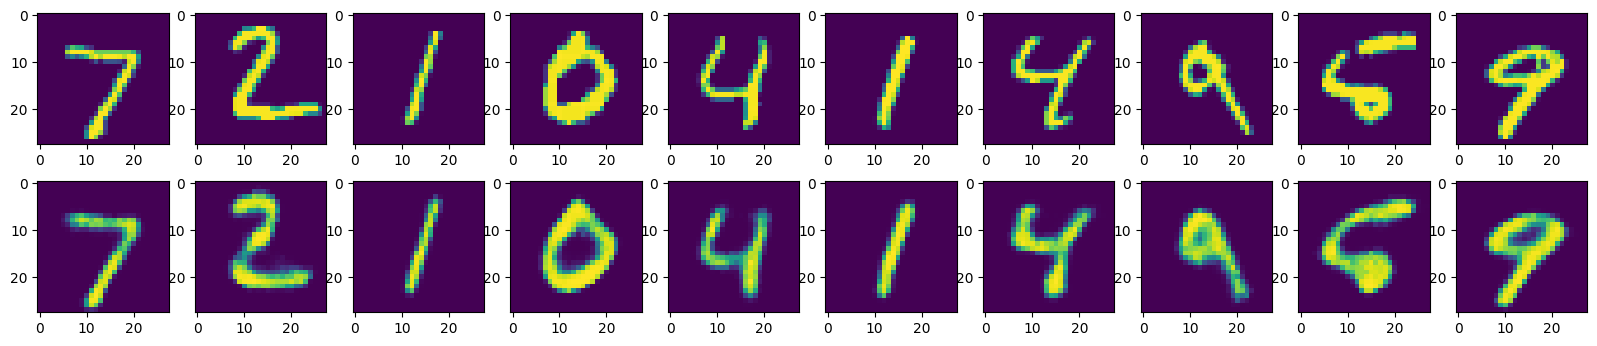

In [92]:
# Test the model
model.eval()
test_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=16, pin_memory=True)
with torch.no_grad():
    img, _ = next(iter(test_loader))
    img = img.to(device)
    output = model(img)
    img = img.cpu()
    output = output.cpu()

    fig, ax = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        ax[0, i].imshow(img[i].squeeze())
        ax[1, i].imshow(output[i].squeeze())